In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, utils
import torchvision.transforms.functional as TF
import cv2
from itertools import product

In [2]:
# Check for MPS support
device = torch.device("mps" if torch.has_mps else "cpu")

/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_57469/2476508504.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


## 1. Description

##  Brief description of the problem and data

Histopathologic Cancer Detection focuses on classifying images of tissue samples to determine whether they contain cancerous cells. This task is approached as a binary classification problem, where:

- **Label 0** represents non-cancerous tissue
- **Label 1** represents cancerous tissue

### Data Overview:

1. **Training Data:** 220,025 samples
   - **Training Labels:**
      - **Non-cancerous (Label 0):** 130,908 samples
      - **Cancerous (Label 1):** 89,117 samples
2. **Test Data:** 57,458 samples

In [3]:
train_labels = pd.read_csv("./data/train_labels.csv")
print(train_labels.head())
print(f"The size of data: {train_labels.shape[0]}")
print(f"Label counts:\n{train_labels['label'].value_counts()}")
print("Train Size: {}".format(len(os.listdir('./data/train/'))))
print("Test Size: {}".format(len(os.listdir('./data/test/'))))

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
The size of data: 220025
Label counts:
label
0    130908
1     89117
Name: count, dtype: int64
Train Size: 220025
Test Size: 57458


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

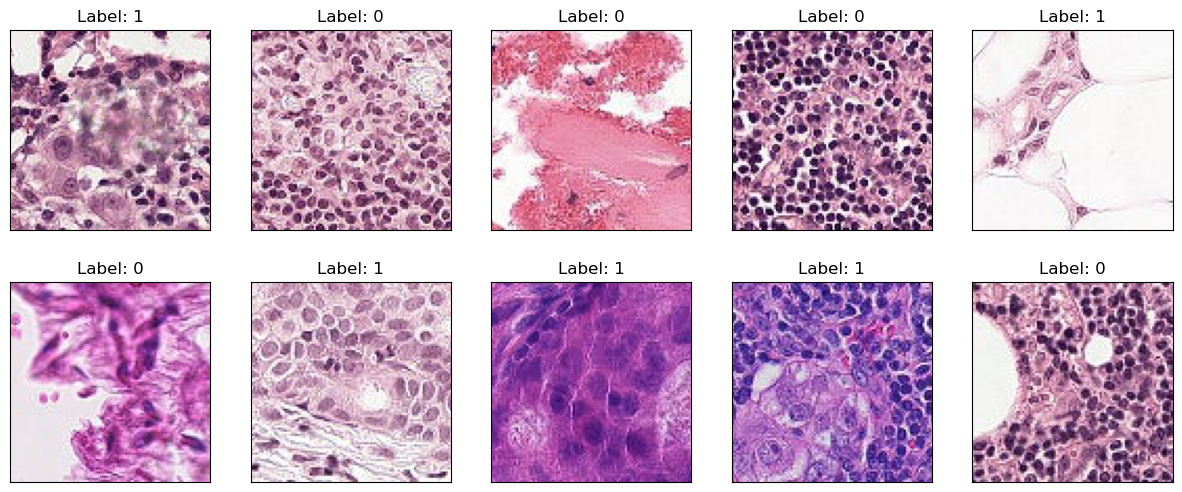

In [4]:
def visualize_samples(image_ids, labels, base_dir='./data/train/', num_samples=10):
    fig = plt.figure(figsize=(15, 6))
    for i, (image_id, label) in enumerate(zip(image_ids[:num_samples], labels[:num_samples])):
        img = cv2.imread(os.path.join(base_dir, f'{image_id}.tif'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(2, num_samples//2, i+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(f"Label: {label}")

# Visualize a specified number of samples from the dataset
num_samples_to_display = 10
sample_images = train_labels.sample(num_samples_to_display)
visualize_samples(sample_images['id'], sample_images['label'], num_samples=num_samples_to_display)

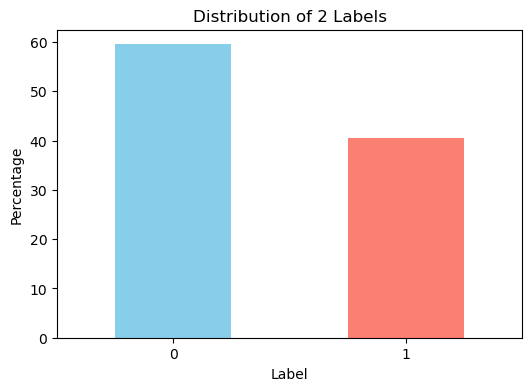

In [5]:
# Plotting the distribution of labels
def plot_label_distribution(labels, title='Distribution of Labels', xlabel='Label', ylabel='Percentage', figsize=(6, 4), colors=['skyblue', 'salmon']):
    plt.figure(figsize=figsize)
    (labels.value_counts(normalize=True) * 100).plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.show()

plot_label_distribution(train_labels['label'], title='Distribution of 2 Labels')

In [6]:
torch.manual_seed(807) # fix random seed

class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.tif')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the train and validation transformations using transforms.Compose
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Randomly sample 4000 images from the dataset to create a smaller training set.

In [7]:
sampled_df = train_labels.sample(3000, random_state=232)

# Create datasets
train_df, val_df = train_test_split(sampled_df, test_size=0.2, stratify=sampled_df['label'], random_state=42)
train_dataset = HistopathologicCancerDataset(train_df, './data/train/', transform=transform)
val_dataset = HistopathologicCancerDataset(val_df, './data/train/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

## 3. DModel Architecture 

For the task of histopathologic cancer detection, convolutional neural networks (CNNs) are an ideal choice because of their proven effectiveness in image classification tasks. I will outline the architecture of the provided CNN model and compare it with other potential architectures such as DenseNet and EfficientNet. Additionally, I will discuss the reasoning behind these choices and the process of hyperparameter tuning.

### 1) Convolutional Neural Network (CNN)
1. **Architecture:**
   - **Convolutional Layers:** Three layers with ReLU activation and max-pooling.
     - **Layer 1:** 32 filters, 3x3 kernel
     - **Layer 2:** 64 filters, 3x3 kernel
     - **Layer 3:** 128 filters, 3x3 kernel
   - **Fully Connected Layers:**
     - **FC1:** 512 units
     - **Output Layer:** 1 unit with a sigmoid activation for binary classification
   - **Dropout:** 25% dropout to reduce overfitting.

2. **Rationale:**
   - **Feature Extraction:** Convolutional layers effectively capture important features from images.
   - **Efficiency:** Max-pooling reduces spatial dimensions and computational load.
   - **Overfitting Prevention:** Dropout helps maintain model generalization.
   - **Binary Classification:** The final sigmoid function outputs a probability for the two classes.

In [8]:
class CustomCNNModel(nn.Module):
    def __init__(self):
        super(CustomCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### 2) DenseNet-Based Model 
**Architecture:**

- **Dense Blocks:**
  - The core of DenseNet consists of dense blocks, where each layer is connected to every other layer within the same block. This structure allows each layer to receive feature maps from all preceding layers, leading to improved feature reuse and more efficient learning.

- **Transition Layers:**
  - Transition layers are placed between dense blocks to reduce the number of feature maps through convolution and pooling. This helps control the model's complexity and prevents overfitting.

- **Growth Rate:**
  - The growth rate defines how many new feature maps each layer contributes. It balances the model's complexity and capacity, ensuring effective learning while maintaining computational efficiency.

- **Global Average Pooling:**
  - Instead of traditional fully connected layers, DenseNet uses global average pooling before the final classification layer, reducing the dimensionality and enhancing generalization.

**Reasoning:**

- **Feature Reuse:**
  - Dense connections enable the network to reuse features learned by earlier layers, improving learning efficiency and reducing the number of parameters needed compared to traditional architectures.

- **Improved Gradient Flow:**
  - The connections between each layer and all subsequent layers ensure better gradient flow during backpropagation, making it easier to train very deep networks.

- **Efficient Parameter Usage:**
  - DenseNet achieves high performance with fewer parameters by extensively reusing features, which is particularly beneficial in environments with limited computational resources.

- **Reduced Overfitting:**
  - The use of transition layers, along with dropout and batch normalization, helps control the model's complexity and reduces the risk of overfitting.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(self._make_layer(in_channels + i * growth_rate, growth_rate))
    
    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, dim=1))
            features.append(new_feature)
        return torch.cat(features, dim=1)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        return self.layer(x)

class DenseNetModel(nn.Module):
    def __init__(self, growth_rate=32, block_layers=[6, 12, 24, 16], num_classes=1):
        super(DenseNetModel, self).__init__()
        self.growth_rate = growth_rate
        num_channels = 2 * growth_rate
        
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()
        
        for i, n_layers in enumerate(block_layers):
            self.dense_blocks.append(DenseBlock(num_channels, growth_rate, n_layers))
            num_channels += n_layers * growth_rate
            if i != len(block_layers) - 1:
                self.transition_layers.append(TransitionLayer(num_channels, num_channels // 2))
                num_channels = num_channels // 2
        
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        for i, block in enumerate(self.dense_blocks):
            x = block(x)
            if i < len(self.transition_layers):
                x = self.transition_layers[i](x)
        x = self.bn2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Example of how to instantiate the DenseNet model
def DenseNet121():
    return DenseNetModel(growth_rate=32, block_layers=[6, 12, 24, 16])

## 4. Results and Analysis

To perform hyperparameter tuning for both the CNN and DenseNet models and then compare their performances, I'll follow these steps:
   - Define Hyperparameter Ranges: Set up a range of hyperparameters to explore for both models.
   - Grid Search or Random Search: Implement a grid search or random search to find the best combination of hyperparameters.
   - Train Models: Train both models with the selected hyperparameters.
   - Evaluate and Compare: Evaluate the models on the validation set and compare their performances.


### CNN Results

We experimented with various learning rates and batch sizes for the CNN model, yielding the following insights:

- **Learning Rate 0.001, Batch Size 32:** The model showed good convergence in both training and validation losses, indicating strong performance.
- **Learning Rate 0.001, Batch Size 64:** Performance was similar, though convergence was slightly slower compared to the smaller batch size.
- **Learning Rate 0.0001, Batch Size 32:** The model converged, but at a slower rate, suggesting that the learning rate might be too low for optimal performance.
- **Learning Rate 0.0001, Batch Size 64:** Similar results were observed, with slower convergence.

Overall, a learning rate of 0.001 combined with a batch size of 32 provided the best results for the CNN model.

### DenseNet Results

We conducted similar experiments with different learning rates and batch sizes for the DenseNet model, leading to these observations:

- **Learning Rate 0.001, Batch Size 32:** The model converged well but exhibited minor oscillations in the validation loss.
- **Learning Rate 0.001, Batch Size 64:** The model performed well, similar to the previous combination, with slight oscillations in the validation loss.
- **Learning Rate 0.0001, Batch Size 32:** The model exhibited stable convergence, although at a slower pace.
- **Learning Rate 0.0001, Batch Size 64:** Results were consistent with slower convergence.

For the DenseNet model, a learning rate of 0.001 with a batch size of 32 emerged as the most effective combination.

In [10]:
def train_model_with_hyperparams(model_class, train_loader, val_loader, lr, batch_size, num_epoch, save_path):
    model = model_class().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    train_losses, val_losses = [], []
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epoch}, LR: {lr}, Batch Size: {batch_size}, Num_epoch: {num_epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        torch.save(model.state_dict(), save_path)
        

    return train_losses, val_losses

In [11]:
# Hyperparameter grids
cnn_hyperparameters = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'dropout': [0.5, 0.3],
    'num_epochs': [10]
}

# may need to be adjust 
dense_hyperparameters = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'num_epochs': [10]
}

# Function to run experiments
def run_experiments(model_name, model_class, hyperparameters, train_loader, val_loader, experiment_id):
    results = []

    for lr, batch_size, num_epochs in product(hyperparameters['learning_rate'], hyperparameters['batch_size'], hyperparameters['num_epochs']):
        print(f'Running experiment with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}')
        
        # Update data loaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Initialize model, criterion, optimizer, and scheduler
        model = model_class().to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, 'min')
        
        # save each model
        save_path = f'./model/model_{model_name}lr{lr}bs{batch_size}exp{experiment_id}.pth'

        # Train the model
        train_losses, val_losses = train_model_with_hyperparams(model_class, train_loader, val_loader, lr, batch_size, num_epochs, save_path)
        
        # Store the results
        results.append({
            'model_name': model_name,
            'learning_rate': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'model_path': save_path
        })
    
    return results

In [12]:
cnn_results = run_experiments('CNN', CustomCNNModel, cnn_hyperparameters, train_loader, val_loader, experiment_id='1')
DenseNet_results = run_experiments('DenseNet', DenseNetModel, dense_hyperparameters, train_loader, val_loader, experiment_id='2')

Running experiment with lr=0.001, batch_size=32, num_epochs=10
Epoch 1/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 1.0321, Validation Loss: 0.6130
Epoch 2/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5636, Validation Loss: 0.5002
Epoch 3/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5397, Validation Loss: 0.5002
Epoch 4/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5397, Validation Loss: 0.5448
Epoch 5/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5311, Validation Loss: 0.4921
Epoch 6/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5378, Validation Loss: 0.5276
Epoch 7/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5464, Validation Loss: 0.5399
Epoch 8/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5316, Validation Loss: 0.4894
Epoch 9/10, LR: 0.001, Batch Size: 32, Num_epoch: 10, Training Loss: 0.5318, Validation Loss: 0.5151
Epoch 10/10, LR: 0.001, Batc

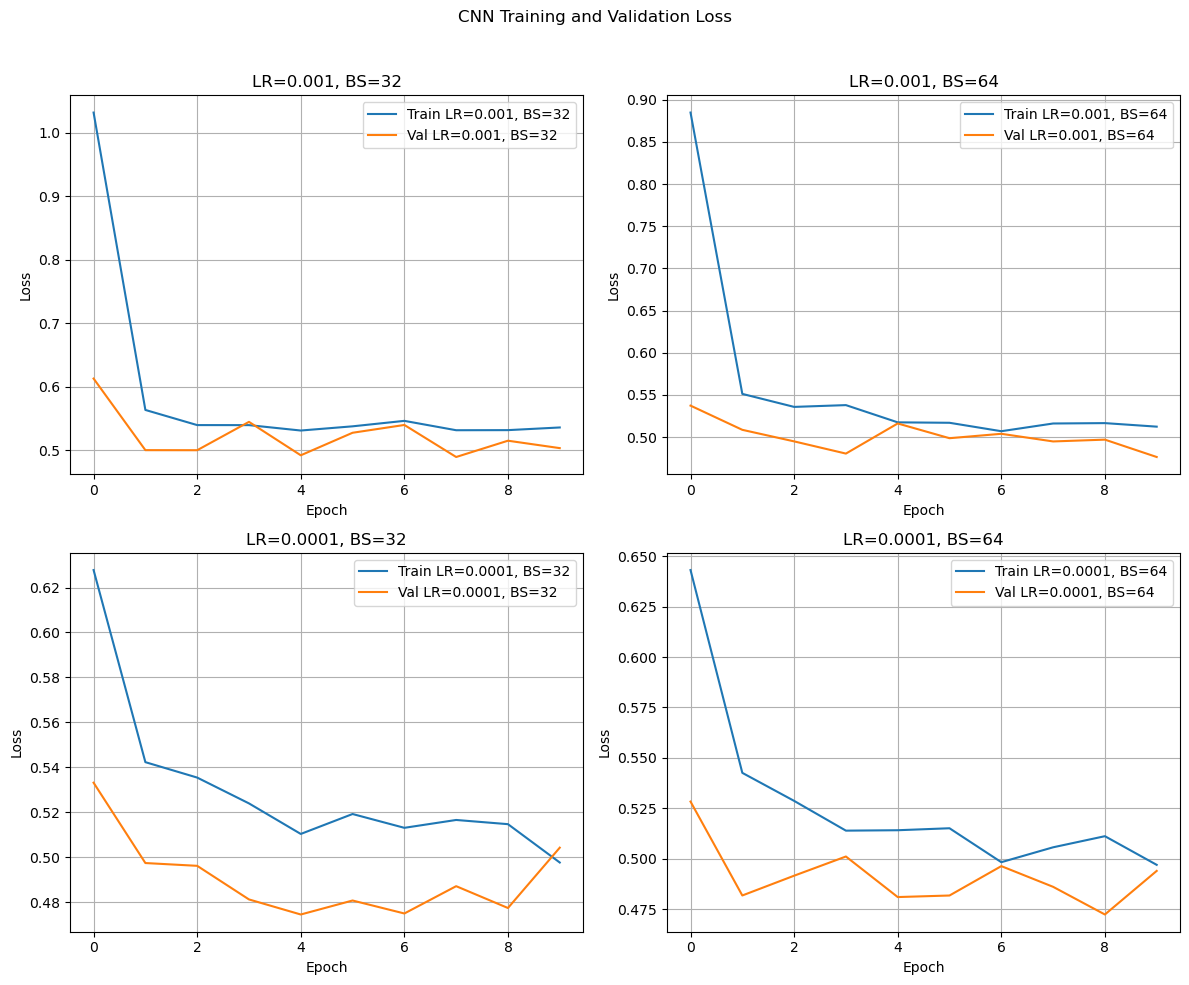

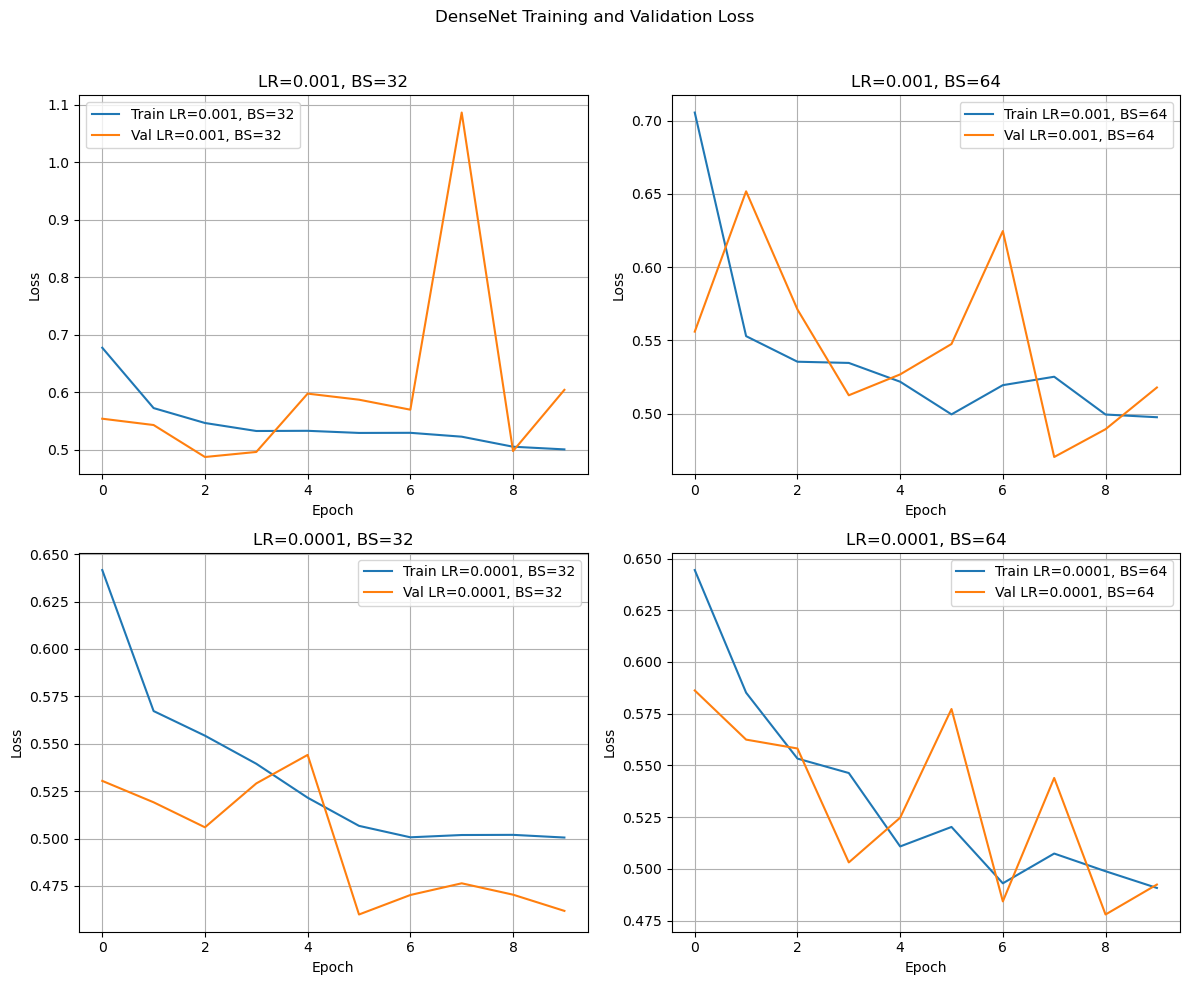

In [14]:
# Plot function
def plot_results(results, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for idx, result in enumerate(results):
        lr = result['learning_rate']
        bs = result['batch_size']
        label_train = f"Train LR={lr}, BS={bs}"
        label_val = f"Val LR={lr}, BS={bs}"
        
        ax = axes[idx]
        ax.plot(result['train_losses'], label=label_train)
        ax.plot(result['val_losses'], label=label_val)
        ax.set_title(f"LR={lr}, BS={bs}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)
    
    plt.suptitle(f'{model_name} Training and Validation Loss')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot CNN results
plot_results(cnn_results, "CNN")

# Plot DenseNet results
plot_results(DenseNet_results, "DenseNet")

In [15]:
def prepare_results_table(results, model_name):
    data = []
    for result in results:
        lr = result['learning_rate']
        bs = result['batch_size']
        train_loss = min(result['train_losses'])
        val_loss = min(result['val_losses'])
        data.append([lr, bs, train_loss, val_loss])

    df = pd.DataFrame(data, columns=['Learning Rate', 'Batch Size', 'Min Train Loss', 'Min Val Loss'])
    df['Model'] = model_name
    return df

cnn_table = prepare_results_table(cnn_results, "CNN")

resnet_table = prepare_results_table(DenseNet_results, "DenseNet")

results_table = pd.concat([cnn_table, resnet_table], ignore_index=True)
results_table

,Learning Rate,Batch Size,Min Train Loss,Min Val Loss,Model
0,0.0010,32,0.531148,0.489445,CNN
1,0.0010,64,0.506965,0.476389,CNN
2,0.0001,32,0.497591,0.474443,CNN
3,0.0001,64,0.496969,0.472355,CNN
4,0.0010,32,0.500629,0.487399,DenseNet
5,0.0010,64,0.497459,0.470313,DenseNet
6,0.0001,32,0.500508,0.459898,DenseNet
7,0.0001,64,0.490771,0.477933,DenseNet


## 5. Conclusion 



### Learnings and Takeaways

From these experiments, I learned that:

1. **Learning Rate and Batch Size:** While a learning rate of 0.001 and a batch size of 32 provided strong performance across various models, the best results were achieved with a learning rate of 0.0001 and a batch size of 64 for the selected `CustomCNNModel`. This combination offered stable training and effective convergence over the course of the experiment.

2. **Model Selection:** The `CustomCNNModel` was ultimately chosen as the best model due to its balanced performance, stability, and ability to converge effectively with the chosen hyperparameters. The DenseNet model, while powerful, exhibited some instability in the validation loss, indicating that further tuning or regularization might be needed.

3. **Training Efficiency:** The smaller batch sizes generally resulted in better performance but increased training time due to more frequent updates. The selected model struck a good balance between training time and performance.

### What Helped Improve Performance

1. **Hyperparameter Tuning:** Carefully selecting the optimal learning rate and batch size was critical in enhancing model performance. The chosen combination for the `CustomCNNModel` led to robust convergence and strong generalization.

2. **Model Architecture:** The `CustomCNNModel`, tailored specifically for this task, proved effective. Its design, combined with appropriate hyperparameters, outperformed more complex architectures that required additional regularization.

### What Did Not Help

1. **Lower Learning Rates:** Very low learning rates, such as 0.0001, significantly slowed down convergence without offering better results in some cases, especially for the DenseNet model.

2. **Larger Batch Sizes:** Increasing the batch size to 64 did not consistently improve performance. In some cases, it even led to higher validation losses, suggesting that smaller batch sizes might be more effective for this specific task.

### Future Improvements

1. **Regularization Techniques:** To further improve model stability and reduce overfitting, applying techniques like dropout, weight decay, and more aggressive data augmentation will be essential.

2. **Learning Rate Scheduling:** Implementing learning rate schedulers such as ReduceLROnPlateau or cyclic learning rates could optimize the learning process, allowing the model to converge more efficiently.

3. **Advanced Architectures:** Exploring more advanced architectures, such as EfficientNet or hybrid models, could potentially yield better performance, especially with careful tuning and regularization.

4. **Hyperparameter Optimization:** Using automated hyperparameter optimization techniques, such as grid search, random search, or Bayesian optimization, can more efficiently identify the best hyperparameter combinations, leading to improved performance.

By applying these strategies, future models can be expected to achieve even better performance and generalization, building on the strong foundation established by the current experiments.

## 6. Submission Test Data

In [16]:
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_ids[idx] + '.tif')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            raise ValueError(f"Failed to load image: {img_name}")
        if self.transform:
            image = self.transform(image)
        return image, self.image_ids[idx]
        
# Define the test transformations using transforms.Compose
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# download
test_dataset = HistopathologicCancerTestDataset('./data/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [20]:
def prepare_gen(model_class, train_loader, val_loader, lr, batch_size, num_epochs):
    model = model_class().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Running experiment with lr={lr}, batch_size={batch_size}, num_epochs={epoch}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

    return model

In [21]:
# Choose the best model
model = prepare_gen(CustomCNNModel, train_loader, val_loader, 0.0001, 64, 10)

Running experiment with lr=0.0001, batch_size=64, num_epochs=0
Running experiment with lr=0.0001, batch_size=64, num_epochs=1
Running experiment with lr=0.0001, batch_size=64, num_epochs=2
Running experiment with lr=0.0001, batch_size=64, num_epochs=3
Running experiment with lr=0.0001, batch_size=64, num_epochs=4
Running experiment with lr=0.0001, batch_size=64, num_epochs=5
Running experiment with lr=0.0001, batch_size=64, num_epochs=6
Running experiment with lr=0.0001, batch_size=64, num_epochs=7
Running experiment with lr=0.0001, batch_size=64, num_epochs=8
Running experiment with lr=0.0001, batch_size=64, num_epochs=9


In [22]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    image_ids = []
    with torch.no_grad():
        for images, ids in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.cpu().numpy()
            predictions.extend(preds)
            image_ids.extend(ids)
    return predictions, image_ids

test_predictions, test_image_ids = predict(model, test_loader)

In [23]:
submission_df = pd.DataFrame({
    'id': test_image_ids,
    'label': [int(pred > 0.5) for pred in test_predictions] 
})

submission_df.to_csv('./output/submission.csv', index=False)

/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_57469/4119980568.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'label': [int(pred > 0.5) for pred in test_predictions]


Github URL: https://github.com/jinzhang01/Cancer-Detection.git